# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (UTI), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [128]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

In [129]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [130]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [131]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [132]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [133]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [134]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [135]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [136]:
data.shape

(108000, 156)

In [137]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,admitted_date,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,81000,10800,10800,10800,10800,10800,10800,0.0,54000,32400,...,108000.000000,108000.000000,108000.000000,108000.000000,108000.000000,108000.000000,108000.000000,108000.000000,108000.000000,108000
unique,38,38,38,13,13,1142,1142,NaN,762,1142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2019-05,2020-05,2020-10,2018-08,2018-08,2021-05-26,2020-11-21,NaN,2022-02-12,2019-12-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,2294,329,319,990,961,20,22,NaN,482,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,15024.923194,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,8675.717048,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7488.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15030.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22542.000000,NaN


In [138]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'deregistered_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_urti_1', 'gp_cons_urti_2', 'gp_cons_urti_3', 'gp_cons_urti_4', 'gp_cons_uti_ab_1', 'gp_cons_uti_ab_2', 'gp_cons_uti_ab_3', 'gp_cons_uti_ab_4', 'gp_cons_urti_ab_1', 'gp_cons_urti_ab_2', 'gp_cons_urti_ab_3', 'gp_cons_urti_ab_4', 'incdt_lrti_date_1', 'incdt_lrti_date_2', 'incdt_lrti_date_3', 'incdt_lrti_date_4', 'admitted_uti_date_1', 'admitted_uti_date_2', 'admitted_uti_date_3', 'admitted_uti_date_4', 'admitted_urti_date_1', 'a

In [139]:
# define dictionaries
dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [140]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [141]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [142]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [143]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     14321
3.0     13806
1.0     12867
4.0     12740
0.0     10214
5.0      9451
6.0      8660
7.0      6601
8.0      5224
9.0      4154
10.0     3301
11.0     2368
12.0     1611
13.0     1064
14.0      617
15.0      404
16.0      260
17.0      160
18.0       83
19.0       57
20.0       20
21.0       10
23.0        4
22.0        3
Name: CCI, dtype: int64

In [144]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots
### 2-1- Continuous factors

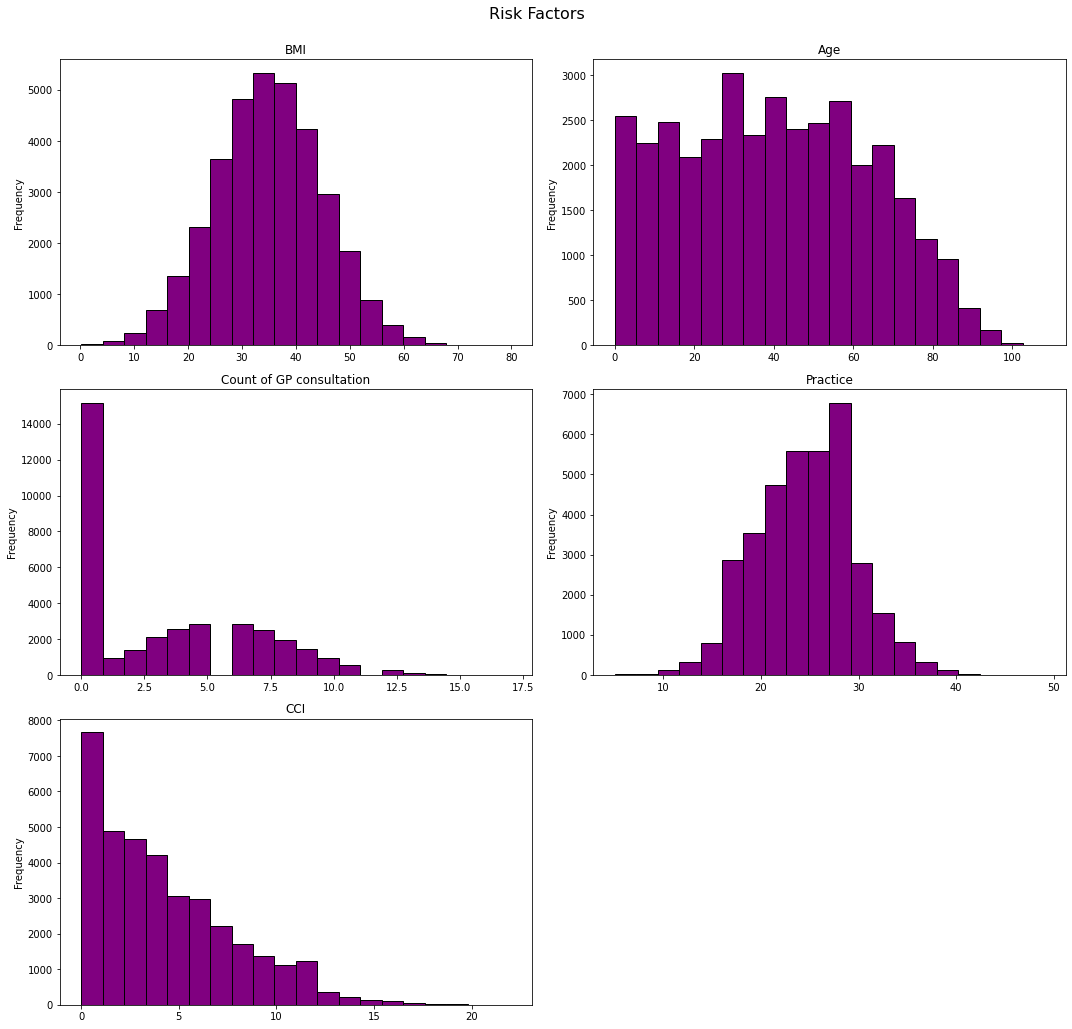

In [28]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [29]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot

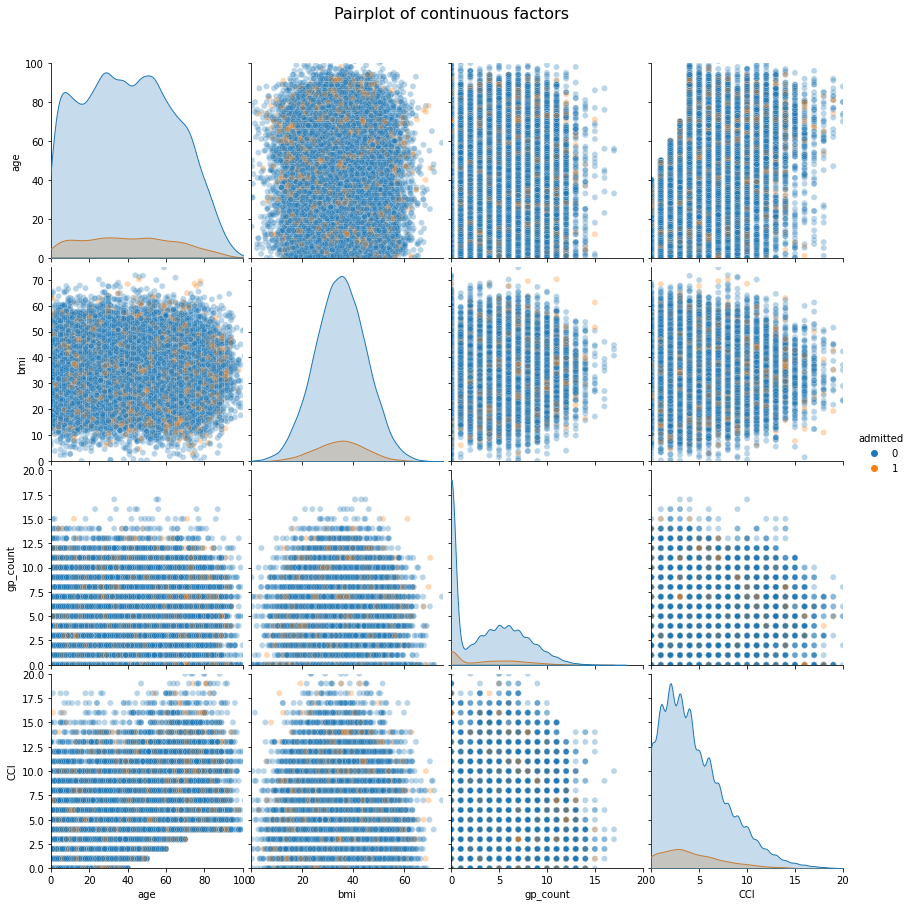

In [30]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

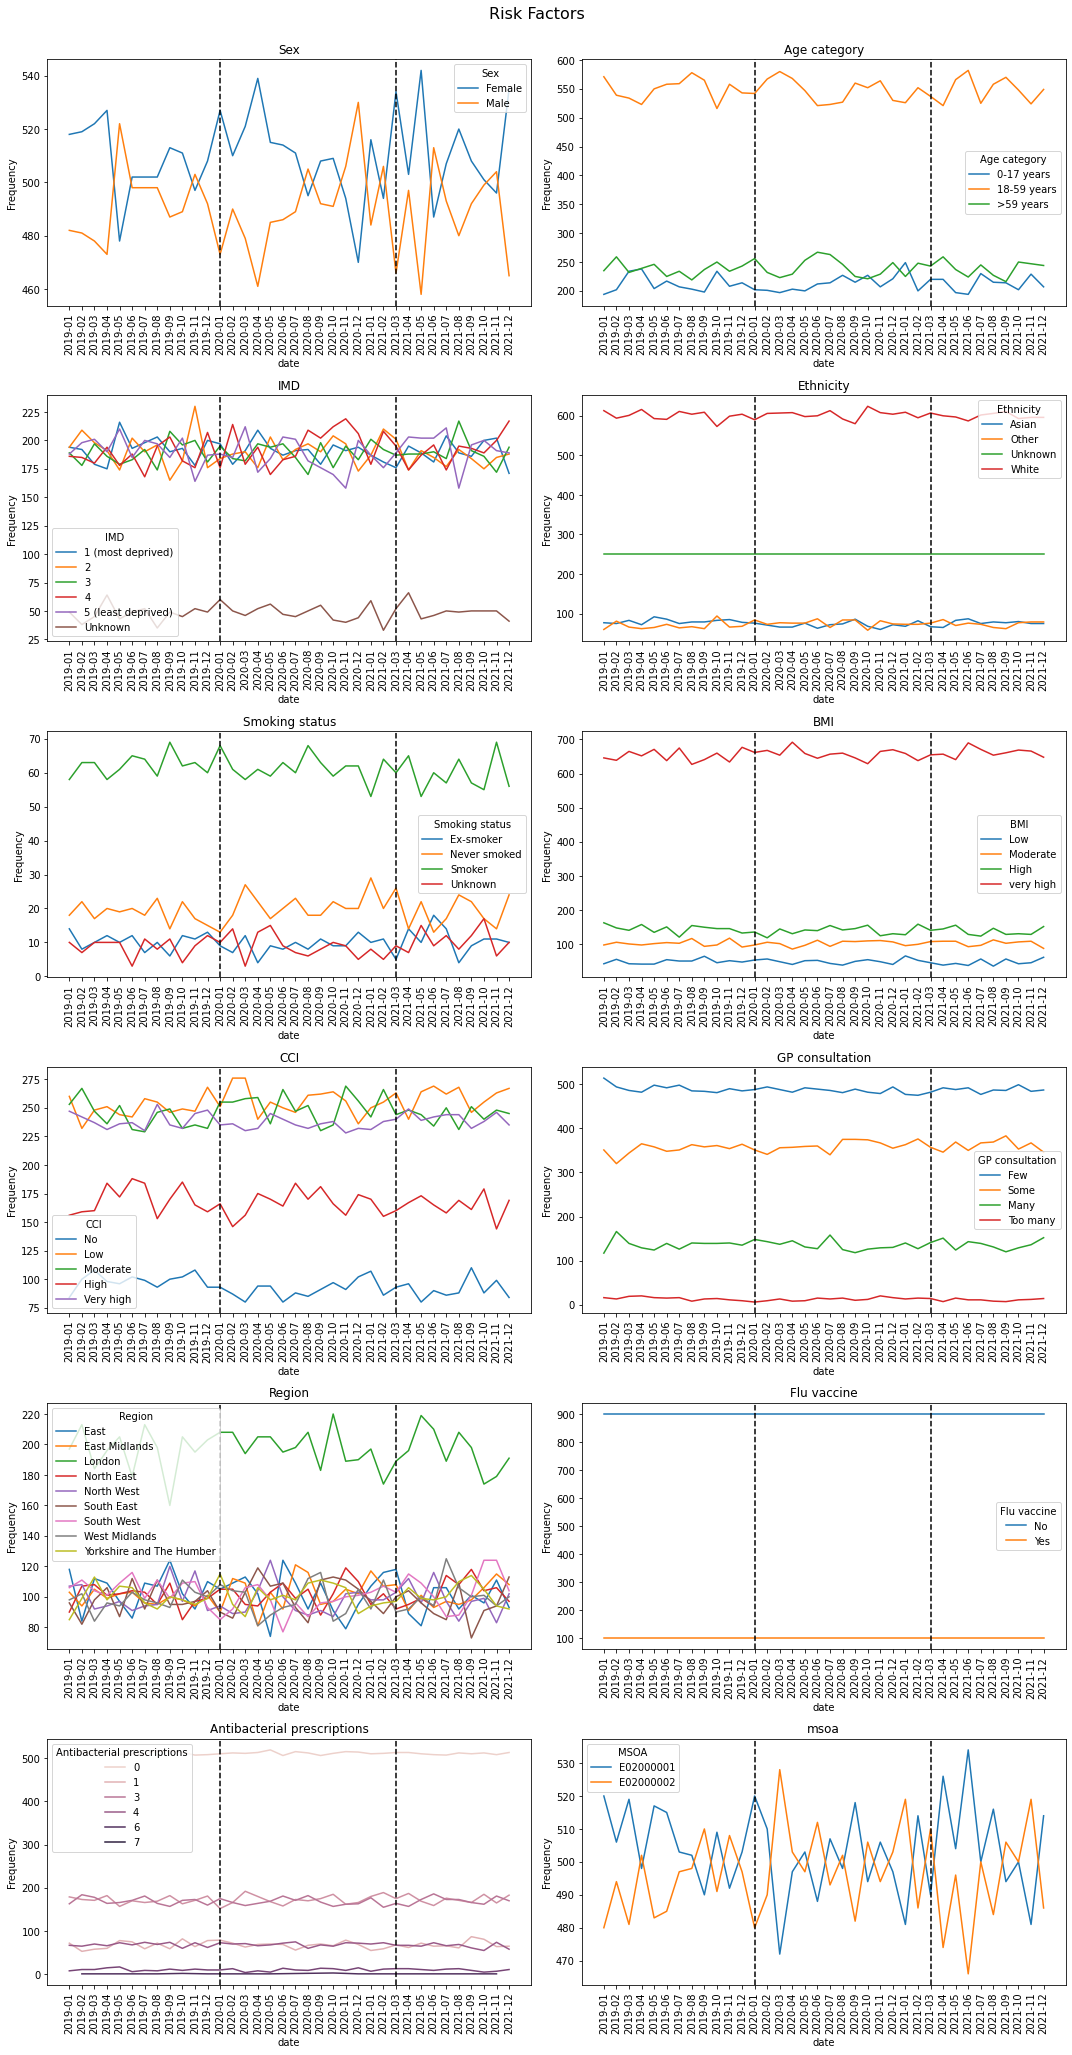

In [31]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- UTI

In [145]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [146]:
# ConvertColumns("uti", 4)

# data_uti_1 = LoadData("uti")
# ExcludeCovid("uti", data_uti_1)

# 'everything else you need to do...'

# data_urti_1 = LoadData("utri")

# def ConvertColumns(InfectionKey, NumSets) :
#     for i in range(1, NumSets+1):        
#         arrayKey = 'admitted_'+InfectionKey+'_date_'+str(i)
#         data[arrayKey] = data[arrayKey].astype('datetime64[ns]')

#### UTI-1

In [147]:
def LoadData(InfectionKey, Index):
    data_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_'+InfectionKey+'_'+str(Index), 'gp_cons_'+InfectionKey+'_ab_'+str(Index),
                    InfectionKey+'_date_'+str(Index), 'incdt_'+InfectionKey+'_date_'+str(Index), 'admitted_'+InfectionKey+'_date_'+str(Index),
                    'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)]]

    data_1 = data_1[data_1[InfectionKey+'_date_'+str(Index)].notnull()]

    data_1.shape

    return data_1

In [37]:
def ExcludeCovid(InfectionKey, DataSet, Index):
# exclusion of covid positive 90 days before and 30 days after dx with uti_1
    data_1 = DataSet[DataSet['sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)] == 0]
    data_1.shape

(3242, 21)

In [38]:
data_uti_1.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_1', 'gp_cons_uti_ab_1',
       'uti_date_1', 'incdt_uti_date_1', 'admitted_uti_date_1',
       'sgss_gp_cov_uti_date_1'],
      dtype='object')

#### UTI-1

In [148]:
data_uti_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_1', 'gp_cons_uti_ab_1',
                    'uti_date_1', 'incdt_uti_date_1', 'admitted_uti_date_1',
                    'sgss_gp_cov_uti_date_1']]

data_uti_1 = data_uti_1[data_uti_1['uti_date_1'].notnull()]

data_uti_1.shape

(288, 21)

In [149]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_1
data_uti_1 = data_uti_1[data_uti_1['sgss_gp_cov_uti_date_1'] == 0]
data_uti_1.shape

(253, 21)

In [150]:
data_uti_1.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_1', 'gp_cons_uti_ab_1',
       'uti_date_1', 'incdt_uti_date_1', 'admitted_uti_date_1',
       'sgss_gp_cov_uti_date_1'],
      dtype='object')

#### UTI-2

In [151]:
data_uti_2 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_2', 'gp_cons_uti_ab_2',
                    'uti_date_2', 'incdt_uti_date_2', 'admitted_uti_date_2',
                    'sgss_gp_cov_uti_date_2']]

data_uti_2 = data_uti_2[data_uti_2['uti_date_2'].notnull()]

data_uti_2.shape

(290, 21)

In [152]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_2
data_uti_2 = data_uti_2[data_uti_2['sgss_gp_cov_uti_date_2'] == 0]
data_uti_2.shape

(262, 21)

In [153]:
data_uti_2.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_2', 'gp_cons_uti_ab_2',
       'uti_date_2', 'incdt_uti_date_2', 'admitted_uti_date_2',
       'sgss_gp_cov_uti_date_2'],
      dtype='object')

#### UTI_3

In [154]:
data_uti_3 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_3', 'gp_cons_uti_ab_3',
                    'uti_date_3', 'incdt_uti_date_3', 'admitted_uti_date_3',
                    'sgss_gp_cov_uti_date_3']]

data_uti_3 = data_uti_3[data_uti_3['uti_date_3'].notnull()]

data_uti_3.shape

(277, 21)

In [155]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_3
data_uti_3 = data_uti_3[data_uti_3['sgss_gp_cov_uti_date_3'] == 0]
data_uti_3.shape

(253, 21)

In [156]:
data_uti_3.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_3', 'gp_cons_uti_ab_3',
       'uti_date_3', 'incdt_uti_date_3', 'admitted_uti_date_3',
       'sgss_gp_cov_uti_date_3'],
      dtype='object')

#### UTI_4

In [157]:
data_uti_4 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_4', 'gp_cons_uti_ab_4',
                    'uti_date_4', 'incdt_uti_date_4', 'admitted_uti_date_4',
                    'sgss_gp_cov_uti_date_4']]

data_uti_4 = data_uti_4[data_uti_4['uti_date_4'].notnull()]

data_uti_4.shape

(289, 21)

In [158]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_4
data_uti_4 = data_uti_4[data_uti_4['sgss_gp_cov_uti_date_4'] == 0]
data_uti_4.shape

(253, 21)

In [159]:
data_uti_4.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_4', 'gp_cons_uti_ab_4',
       'uti_date_4', 'incdt_uti_date_4', 'admitted_uti_date_4',
       'sgss_gp_cov_uti_date_4'],
      dtype='object')

#### Combining UTI_1, UTI_2, UTI_3, and UTI_4

In [160]:
data_uti_1.rename(columns={'uti_date_1': 'uti_date', 'incdt_uti_date_1': 'incdt_uti_date', 
                           'gp_cons_uti_1': 'gp_cons_uti', 'gp_cons_uti_ab_1': 'gp_cons_uti_ab',
                           'incdt_uti_date_1': 'incdt_uti_date', #'prevl_uti_date_1': 'prevl_uti_date',
                           'admitted_uti_date_1': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_1': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_2.rename(columns={'uti_date_2': 'uti_date', 'incdt_uti_date_2': 'incdt_uti_date',
                           'gp_cons_uti_2': 'gp_cons_uti', 'gp_cons_uti_ab_2': 'gp_cons_uti_ab',
                           'incdt_uti_date_2': 'incdt_uti_date', #'prevl_uti_date_2': 'prevl_uti_date', 
                           'admitted_uti_date_2': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_2': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_3.rename(columns={'uti_date_3': 'uti_date', 'incdt_uti_date_3': 'incdt_uti_date',
                           'gp_cons_uti_3': 'gp_cons_uti', 'gp_cons_uti_ab_3': 'gp_cons_uti_ab',
                           'incdt_uti_date_3': 'incdt_uti_date', #'prevl_uti_date_3': 'prevl_uti_date', 
                           'admitted_uti_date_3': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_3': 'sgss_gp_cov_uti_date'},
                 inplace=True)
data_uti_4.rename(columns={'uti_date_4': 'uti_date', 'incdt_uti_date_4': 'incdt_uti_date', 
                           'gp_cons_uti_4': 'gp_cons_uti', 'gp_cons_uti_ab_4': 'gp_cons_uti_ab',
                           'incdt_uti_date_4': 'incdt_uti_date', #'prevl_uti_date_4': 'prevl_uti_date',
                           'admitted_uti_date_4': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_4': 'sgss_gp_cov_uti_date'}, 
                 inplace=True)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(1021, 21)

In [161]:
data_uti.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date'],
      dtype='object')

In [162]:
data_uti.shape

(1021, 21)

#### Adding event and duration columns

In [163]:
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
#data_uti['incdt_uti_date'] = data_uti['incdt_uti_date'].astype('datetime64[ns]')
data_uti['died_date'] = data_uti['died_date'].astype('datetime64[ns]')
data_uti.shape

(1021, 21)

In [164]:
# drop any case that has no admitted_uti_date
data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]
data_uti.shape

(331, 21)

In [165]:
#I should ensure that incdt_uti_date is the same as uti_date and then apply this section for the entire uti data
# data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['incdt_uti_date']).dt.days
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti['delta_uti_admitted'].value_counts()

430     3
1057    3
345     3
1065    2
845     2
       ..
482     1
598     1
854     1
562     1
357     1
Name: delta_uti_admitted, Length: 288, dtype: int64

In [166]:
# # I deactivate this cell because I think dummy data leads to  
# data_uti.loc[data_uti['delta_uti_admitted'] > 30, 'delta_uti_admitted'] = 0
# data_uti.loc[data_uti['delta_uti_admitted'] < 0, 'delta_uti_admitted'] = 0 
# data_uti['delta_uti_admitted'].value_counts()

In [167]:
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days

#give nan to any case that died before admission! (this happens because of dummy data??)
# data_uti.loc[data_uti['delta_uti_admitted'] < 0, 'delta_uti_admitted'] = np.nan
data_uti = data_uti[data_uti['delta_uti_admitted'] > 0]

data_uti['delta_admitted_died'].isnull().sum()

287

In [168]:
#censor died cases
data_uti.loc[data_uti['delta_admitted_died'] > 30, 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    33
Name: event_uti_admitted, dtype: int64

In [169]:
#censor cases that had a history of hospital admission
data_uti.loc[data_uti['hx_hosp'] == 1, 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    34
Name: event_uti_admitted, dtype: int64

In [170]:
#uncensor any other cases
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 1)
data_uti['event_uti_admitted'].value_counts()

1.0    290
0.0     34
Name: event_uti_admitted, dtype: int64

In [171]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died'])
data_uti['duration_uti_admitted']#.value_counts()

7       1065
8        356
11       227
16       120
27       986
        ... 
1001     952
1005     702
1007     940
1011     357
1013    1057
Name: duration_uti_admitted, Length: 324, dtype: int64

In [173]:
data_uti.shape#['duration_uti_admitted'].value_counts()

(324, 25)

In [174]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=0, fontsize=12)                        
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/corr_uti.jpg')
# plt.show()

#### Separate data of UTI
We separate data of UTI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [175]:
# no antibiotics and incident hospital admission
#data_uti_no_abs_incdt = data_uti[~data_uti['gp_cons_uti_ab'].notnull() & data_uti['incdt_uti_date'].notnull()]
data_uti_no_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
#data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'].notnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]
data_uti_no_abs_incdt.shape

(268, 25)

In [176]:
# with antibiotics and incident hospital admission
#data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull() & data_uti['incdt_uti_date'].notnull()]
data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
#data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]
data_uti_abs_incdt.shape

(35, 25)

In [177]:
# no antibiotics and prevalent hospital admission
#data_uti_no_abs_prevl = data_uti[~data_uti['gp_cons_uti_ab'].notnull() & data_uti['prevl_uti_date'] == 1]
data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
#data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['uti_date'].notnull()]
#data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'].isnull()]
#data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['prevl_uti_date'] == 1]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]
data_uti_no_abs_prevl.shape

(20, 25)

In [178]:
# with antibiotics and prevalent hospital admission
#data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull() & data_uti['prevl_uti_date'] == 0]
data_uti_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
#data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['uti_date'].notnull()]
#data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'].isnull()]
#data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['prevl_uti_date'] == 1]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]
data_uti_abs_prevl.shape

(1, 25)

### 3-2- URTI

In [48]:
# data['admitted_urti_date_1'] = data['admitted_urti_date_1'].astype('datetime64[ns]')
# data['admitted_urti_date_2'] = data['admitted_urti_date_2'].astype('datetime64[ns]')
# data['admitted_urti_date_3'] = data['admitted_urti_date_3'].astype('datetime64[ns]')
# data['admitted_urti_date_4'] = data['admitted_urti_date_4'].astype('datetime64[ns]')

In [49]:
# data['urti_date_1'].value_counts().sum()

#### URTI-1

In [50]:
# data_urti_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                     'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                     'gp_cons_urti_1', 'gp_cons_urti_ab_1',
#                     'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
#                     'sgss_gp_cov_urti_date_1']]

# data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

# data_urti_1.shape

In [68]:
# # exclusion of covid positive 90 days before and 30 days after dx with urti_1
# data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
# data_urti_1.shape

(3242, 21)

In [51]:
# data_urti_1.columns

#### URTI-2

In [52]:
# data_urti_2 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                     'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                     'gp_cons_urti_2', 'gp_cons_urti_ab_2',
#                     'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
#                     'sgss_gp_cov_urti_date_2']]

# data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

# data_urti_2.shape

In [53]:
# # exclusion of covid positive 90 days before and 30 days after dx with urti_2
# data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
# data_urti_2.shape

In [54]:
# data_urti_2.columns

#### URTI-3

In [55]:
# data_urti_3 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                     'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                     'gp_cons_urti_3', 'gp_cons_urti_ab_3',
#                     'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
#                     'sgss_gp_cov_urti_date_3']]

# data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

# data_urti_3.shape

In [56]:
# # exclusion of covid positive 90 days before and 30 days after dx with urti_3
# data_uti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
# data_urti_3.shape

In [57]:
# data_urti_3.columns

#### URTI-4

In [58]:
# data_urti_4 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                     'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                     'gp_cons_urti_4', 'gp_cons_urti_ab_4',
#                     'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
#                     'sgss_gp_cov_urti_date_4']]

# data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

# data_urti_4.shape

In [59]:
# # exclusion of covid positive 90 days before and 30 days after dx with urti_4
# data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
# data_urti_4.shape

In [60]:
# data_urti_4.columns

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [61]:
# data_urti_1.rename(columns={'urti_date_1': 'urti_date', 'incdt_urti_date_1': 'incdt_urti_date', 
#                            'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
#                            'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
#                            'admitted_urti_date_1': 'admitted_urti_date',
#                            'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
#                 inplace=True)
# data_urti_2.rename(columns={'urti_date_2': 'urti_date', 'incdt_urti_date_2': 'incdt_urti_date',
#                            'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
#                            'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
#                            'admitted_urti_date_2': 'admitted_urti_date',
#                            'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
#                 inplace=True)
# data_urti_3.rename(columns={'urti_date_3': 'urti_date', 'incdt_urti_date_3': 'incdt_urti_date',
#                            'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
#                            'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
#                            'admitted_urti_date_3': 'admitted_urti_date',
#                            'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
#                  inplace=True)
# data_urti_4.rename(columns={'urti_date_4': 'urti_date', 'incdt_urti_date_4': 'incdt_urti_date', 
#                            'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
#                            'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
#                            'admitted_urti_date_4': 'admitted_urti_date',
#                            'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
#                  inplace=True)

# data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
# data_urti.reset_index(inplace=True, drop=True)
# data_urti.shape

In [62]:
# data_urti.columns

#### Adding event and duration columns

In [63]:
# data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
# data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
# #data_urti['incdt_urti_date'] = data_urti['incdt_urti_date'].astype('datetime64[ns]')
# data_urti['died_date'] = data_urti['died_date'].astype('datetime64[ns]')
# data_urti.shape

In [64]:
# # drop any case that has no admitted_urti_date
# data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
# data_urti.shape

In [65]:
# #I should ensure that incdt_urti_date is the same as urti_date and then apply this section for the entire urti data
# # data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['incdt_urti_date']).dt.days
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
# data_urti['delta_urti_admitted'].value_counts()

In [84]:
# # I deactivate this cell because I think dummy data leads to  
# data_urti.loc[data_urti['delta_urti_admitted'] > 30, 'delta_urti_admitted'] = 0
# data_urti.loc[data_urti['delta_urti_admitted'] < 0, 'delta_urti_admitted'] = 0 
# data_urti['delta_urti_admitted'].value_counts()

In [66]:
# data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days

# #give nan to any case that died before admission! (this happens because of dummy data??)
# # data_urti.loc[data_urti['delta_urti_admitted'] < 0, 'delta_urti_admitted'] = np.nan
# data_urti = data_urti[data_urti['delta_urti_admitted'] > 0]

# data_urti['delta_admitted_died'].isnull().sum()

In [67]:
# #censor died cases
# data_urti.loc[data_urti['delta_admitted_died'] > 30, 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

In [68]:
# #censor cases that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

In [69]:
# #uncensor any other cases
# data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 1)
# data_urti['event_urti_admitted'].value_counts()

In [70]:
# #assign values for duration column
# data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died'])
# data_urti['duration_urti_admitted']#.value_counts()

In [90]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=0, fontsize=12)                        
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/corr_urti.jpg')
# plt.show()

In [71]:
# data_urti.shape

#### Separate data of URTI
We separate data of URI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [72]:
# data_urti['gp_cons_urti_ab'].isnull().sum()

In [73]:
# data_urti['incdt_urti_date'].value_counts()

In [74]:
# # no antibiotics and incident hospital admission
# #data_urti_no_abs_incdt = data_urti[~data_urti['gp_cons_urti_ab'].notnull() & data_urti['incdt_urti_date'].notnull()]
# data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
# #data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'].notnull()]
# data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]
# data_urti_no_abs_incdt.shape

In [75]:
# # with antibiotics and incident hospital admission
# #data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull() & data_urti['incdt_urti_date'].notnull()]
# data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
# #data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'].notnull()]
# data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]
# data_urti_abs_incdt.shape

In [76]:
# # no antibiotics and prevalent hospital admission
# #data_urti_no_abs_prevl = data_urti[~data_urti['gp_cons_urti_ab'].notnull() & data_urti['prevl_urti_date'] == 1]
# data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['urti_date'].notnull()]
# #data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'].isnull()]
# #data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['prevl_urti_date'] == 1]
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]
# data_urti_no_abs_prevl.shape

In [77]:
# # with antibiotics and prevalent hospital admission
# #data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull() & data_urti['prevl_urti_date'] == 0]
# data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
# data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['urti_date'].notnull()]
# #data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'].isnull()]
# #data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['prevl_urti_date'] == 1]
# data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]
# data_urti_abs_prevl.shape

## 4- Cox modelling for hospital admissions related to infections 
### 4-1- UTI
#### 4-1-1- Incident hospital admission related to UTI with no antibiotics

In [179]:
data_uti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date',
       'delta_uti_admitted', 'delta_admitted_died', 'event_uti_admitted',
       'duration_uti_admitted'],
      dtype='object')

In [180]:
data_uti_no_abs_incdt.shape

(268, 25)

In [181]:
#keep relevant variables
data_uti_no_abs_incdt = data_uti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                               'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                               'event_uti_admitted', 'duration_uti_admitted']]

In [182]:
# printing number of missing values in each variable 
data_uti_no_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                      60
BMI_cat                  60
gp_count                  0
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [183]:
#drop ros with missing values
data_uti_no_abs_incdt = data_uti_no_abs_incdt.dropna(axis='rows')
# data_uti = data_uti.drop(columns=['smoking_status'])
data_uti_no_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [184]:
dict_sex = {'Female':1, 'Male': 2}
data_uti_no_abs_incdt = data_uti_no_abs_incdt.replace({"sex": dict_sex})

dict_age_cat= {'0-4': 1, '5-14': 2, '15-24': 3, '25-34': 4, '35-44': 5, '45-54': 6, '55-64': 7, '65-74': 8, '75+': 9}
data_uti_no_abs_incdt = data_uti_no_abs_incdt.replace({"age_cat": dict_age_cat})

In [185]:
data_uti_no_abs_incdt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 7 to 1013
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    208 non-null    int64   
 1   age_cat                208 non-null    int64   
 2   sex                    208 non-null    int64   
 3   bmi                    208 non-null    float64 
 4   BMI_cat                208 non-null    category
 5   gp_count               208 non-null    float64 
 6   flu_vaccine            208 non-null    object  
 7   region                 208 non-null    object  
 8   antibacterial_brit     208 non-null    int64   
 9   imd                    208 non-null    object  
 10  ethnicity              208 non-null    object  
 11  CCI_cat                208 non-null    category
 12  CCI                    208 non-null    float64 
 13  event_uti_admitted     208 non-null    float64 
 14  duration_uti_admitted  208 non-null    in

In [186]:
data_uti_no_abs_incdt.shape

(208, 15)

In [109]:
data_uti_no_abs_incdt.event_uti_admitted = data_uti_no_abs_incdt.event_uti_admitted.astype(int)

In [187]:
data_uti_no_abs_incdt_age_sex = data_uti_no_abs_incdt[['age_cat','sex','duration_uti_admitted','event_uti_admitted']]

In [188]:
cph_uti_no_abs_incdt = CoxPHFitter()
cph_uti_no_abs_incdt.fit(data_uti_no_abs_incdt_age_sex, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex"# + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 208 total observations, 24 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 208
number of events observed = 184
   partial log-likelihood = -792.33
         time fit was run = 2022-02-16 17:07:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age_cat    -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
sex         0.04       1.04       0.15            -0.25             0.33                 0.78                 1.39

              z    p   -log2(p)
covariate                      
age_cat   -1.31 0.19       2.40
sex        0.26 0.79       0.34
---
Concordance = 0.55
Partial AIC = 1588.66
log-likelihood ratio test = 1.80 on 2 df
-log2(p) of ll-ratio test = 1.30

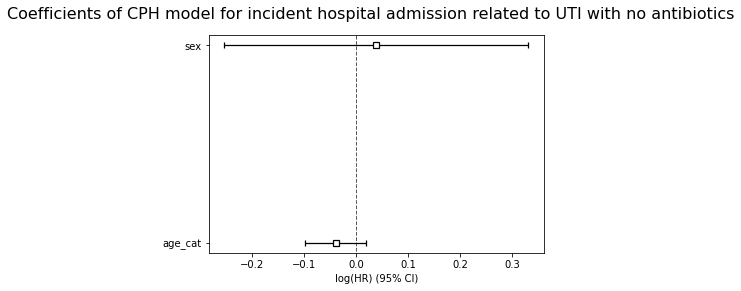

In [189]:
fig, ax = plt.subplots(#figsize=(5, 9)
                        )
cph_uti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [190]:
from lifelines.utils import k_fold_cross_validation

In [197]:
data_uti_no_abs_incdt_age_sex.info()#shape#_age_sex.shape#.age_cat.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 7 to 1013
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_cat                208 non-null    int64  
 1   sex                    208 non-null    int64  
 2   duration_uti_admitted  208 non-null    int64  
 3   event_uti_admitted     208 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 16.2 KB


In [206]:
scores_uti_no_abs_incdt = k_fold_cross_validation(cph_uti_no_abs_incdt, 
                                                      data_uti_no_abs_incdt_age_sex, 
                                                      duration_col='duration_uti_admitted',
                                                      event_col='event_uti_admitted',
                                                      k=10, scoring_method="concordance_index"
                                                      )

In [211]:
sum(scores_uti_no_abs_incdt)/10

0.565191433735948

In [105]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

#### 4-1-2- Incident hospital admission related to UTI with antibiotics

In [106]:
data_uti_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date',
       'delta_uti_admitted', 'delta_admitted_died', 'event_uti_admitted',
       'duration_uti_admitted'],
      dtype='object')

In [107]:
data_uti_abs_incdt.shape

(178, 25)

In [108]:
#keep relevant variables
data_uti_abs_incdt = data_uti_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_uti_admitted', 'duration_uti_admitted']]

In [109]:
# printing number of missing values in each variable 
data_uti_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                      11
BMI_cat                  11
gp_count                  1
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [110]:
#drop ros with missing values
data_uti_abs_incdt = data_uti_abs_incdt.dropna(axis='rows')
#data_uti_abs_incdt = data_uti_abs_incdt.drop(columns=['smoking_status'])
data_uti_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [111]:
data_uti_abs_incdt.shape

(166, 15)

In [112]:
cph_uti_abs_incdt = CoxPHFitter(penalizer=0.1)
cph_uti_abs_incdt.fit(data_uti_abs_incdt, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 166 total observations, 39 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 166
number of events observed = 127
   partial log-likelihood = -519.14
         time fit was run = 2022-02-03 15:14:57 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                    -0.45       0.64       0.35            -1.15             0.24                 0.32                 1.28
age_cat[T.25-34]                    -0.18       0.84       0.32            -0.81             0.45                 0.44                 1.57
age_cat[T.35-44]                    -0.23       0.80       0.35            -0.92             0.47                 0.40                 1.60
age_cat[T.45-54]                    -0.11       0.90       0.33            -0.76             0.54                 0.47                 1.72
age_cat[T.5-14]                     -0.06       0.94       0.41            -0.86             0.74                 0.42                 2.10
age_cat[T.55-64]                     0.52       1.68       0.33            -0.12             1.16                 0.88                 3.20
age_cat[T.65-74]                     0.45       1.57       0.29            -0.13             1.02                 0.88                 2.78
age_cat[T.75+]                       0.33       1.39       0.34            -0.33             0.99                 0.72                 2.69
antibacterial_brit                  -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.12
ethnicity[T.Other]                  -0.20       0.82       0.52            -1.22             0.82                 0.30                 2.27
ethnicity[T.Unknown]                -0.20       0.82       0.33            -0.83             0.44                 0.43                 1.56
ethnicity[T.White]                  -0.15       0.86       0.31            -0.75             0.45                 0.47                 1.57
flu_vaccine[T.Yes]                  -0.06       0.94       0.31            -0.66             0.55                 0.52                 1.73
gp_count                            -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
imd[T.2]                            -0.10       0.90       0.26            -0.62             0.41                 0.54                 1.51
imd[T.3]                            -0.45       0.63       0.27            -0.99             0.08                 0.37                 1.08
imd[T.4]                            -0.25       0.78       0.28            -0.79             0.30                 0.45                 1.35
imd[T.5 (least deprived)]           -0.10       0.90       0.26            -0.62             0.42                 0.54                 1.52
imd[T.Unknown]                      -0.75       0.47       0.59            -1.90             0.40                 0.15                 1.49
region[T.East Midlands]              0.14       1.15       0.37            -0.58             0.87                 0.56                 2.38
region[T.London]                    -0.59       0.55       0.29            -1.17            -0.01                 0.31                 0.99
region[T.North East]                -0.00       1.00       0.34            -0.66             0.66                 0.51                 1.94
region[T.North West]                -0.60       0.55       0.41            -1.41             0.21                 0.24                 1.24
region[T.South East]                 0.13       1.

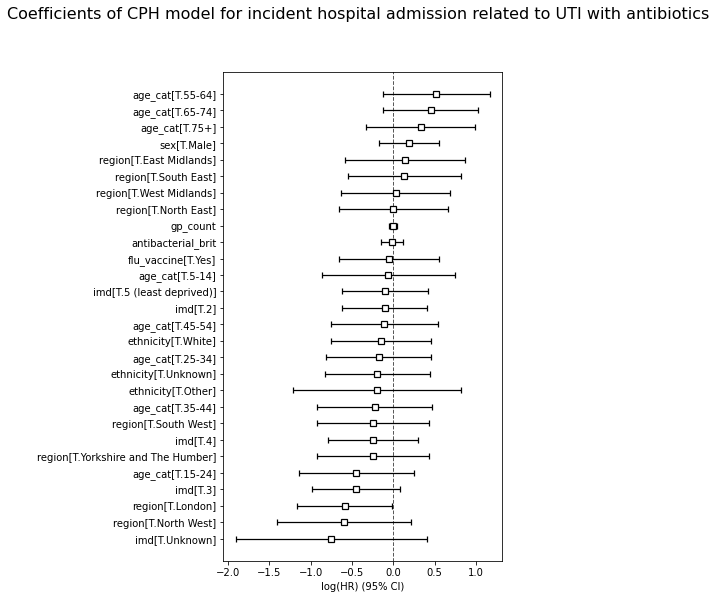

In [113]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [114]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

#### 4-1-3- Prevalent hospital admission related to UTI with no antibiotics

In [115]:
data_uti_no_abs_prevl.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date',
       'delta_uti_admitted', 'delta_admitted_died', 'event_uti_admitted',
       'duration_uti_admitted'],
      dtype='object')

In [116]:
#keep relevant variables
data_uti_no_abs_prevl = data_uti_no_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                                'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                                'event_uti_admitted', 'duration_uti_admitted']]

In [117]:
# printing number of missing values in each variable 
data_uti_no_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      9
BMI_cat                  9
gp_count                 1
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [118]:
#drop ros with missing values
data_uti_no_abs_prevl = data_uti_no_abs_prevl.dropna(axis='rows')
#data_uti_no_abs_prevl = data_uti_no_abs_prevl.drop(columns=['smoking_status'])
data_uti_no_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [119]:
data_uti_no_abs_prevl.shape

(182, 15)

In [120]:
cph_uti_no_abs_prevl = CoxPHFitter(penalizer=0.1)
cph_uti_no_abs_prevl.fit(data_uti_no_abs_prevl, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 182 total observations, 48 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 182
number of events observed = 134
   partial log-likelihood = -553.02
         time fit was run = 2022-02-03 15:14:58 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                    -0.57       0.56       0.36            -1.27             0.12                 0.28                 1.13
age_cat[T.25-34]                    -0.66       0.52       0.31            -1.27            -0.06                 0.28                 0.94
age_cat[T.35-44]                     0.03       1.03       0.33            -0.62             0.68                 0.54                 1.98
age_cat[T.45-54]                    -0.43       0.65       0.30            -1.01             0.15                 0.36                 1.16
age_cat[T.5-14]                     -0.16       0.85       0.36            -0.86             0.54                 0.42                 1.72
age_cat[T.55-64]                    -0.87       0.42       0.35            -1.55            -0.19                 0.21                 0.83
age_cat[T.65-74]                    -0.46       0.63       0.31            -1.06             0.14                 0.35                 1.15
age_cat[T.75+]                       0.24       1.27       0.34            -0.43             0.90                 0.65                 2.46
antibacterial_brit                   0.15       1.16       0.06             0.02             0.27                 1.02                 1.31
ethnicity[T.Other]                   0.74       2.09       0.41            -0.06             1.53                 0.94                 4.64
ethnicity[T.Unknown]                 0.03       1.03       0.30            -0.54             0.61                 0.58                 1.85
ethnicity[T.White]                   0.13       1.14       0.26            -0.38             0.65                 0.69                 1.91
flu_vaccine[T.Yes]                  -0.37       0.69       0.28            -0.91             0.17                 0.40                 1.18
gp_count                            -0.03       0.97       0.03            -0.08             0.03                 0.92                 1.03
imd[T.2]                            -0.16       0.85       0.26            -0.66             0.34                 0.52                 1.41
imd[T.3]                            -0.02       0.98       0.31            -0.62             0.58                 0.54                 1.78
imd[T.4]                            -0.28       0.75       0.26            -0.80             0.23                 0.45                 1.26
imd[T.5 (least deprived)]            0.28       1.33       0.25            -0.20             0.77                 0.82                 2.15
imd[T.Unknown]                       0.06       1.07       0.39            -0.69             0.82                 0.50                 2.27
region[T.East Midlands]             -0.25       0.78       0.32            -0.88             0.37                 0.42                 1.44
region[T.London]                    -0.14       0.87       0.28            -0.70             0.41                 0.50                 1.51
region[T.North East]                 0.18       1.20       0.30            -0.40             0.77                 0.67                 2.15
region[T.North West]                 0.32       1.37       0.38            -0.42             1.05                 0.66                 2.87
region[T.South East]                -0.23       0.

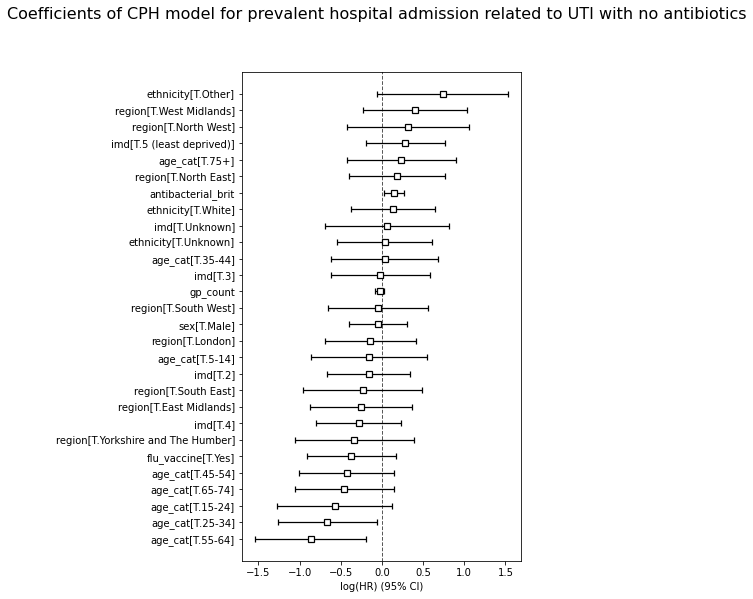

In [121]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [122]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_uti_no_abs_prevl, f)

# with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'rb') as f:
#     cph_uti_no_abs_prevl = pickle.load(f)

# cph_uti_no_abs_prevl.summary

#### 4-1-4- Prevalent hospital admission related to UTI with antibiotics

In [123]:
data_uti_abs_prevl.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'admitted_uti_date', 'sgss_gp_cov_uti_date',
       'delta_uti_admitted', 'delta_admitted_died', 'event_uti_admitted',
       'duration_uti_admitted'],
      dtype='object')

In [124]:
#keep relevant variables
data_uti_abs_prevl = data_uti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_uti_admitted', 'duration_uti_admitted']]

In [125]:
# print number of missing values in each variable 
data_uti_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      2
BMI_cat                  2
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [126]:
#drop ros with missing values
data_uti_abs_prevl = data_uti_abs_prevl.dropna(axis='rows')
#data_uti_abs_prevl = data_uti_abs_prevl.drop(columns=['smoking_status'])
data_uti_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [127]:
cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1)
cph_uti_abs_prevl.fit(data_uti_abs_prevl, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 17 total observations, 3 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 17
number of events observed = 14
   partial log-likelihood = -14.10
         time fit was run = 2022-02-03 15:14:59 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.25-34]                     0.45       1.57       2.22            -3.90             4.80                 0.02               121.72
age_cat[T.35-44]                     1.21       3.35       1.74            -2.21             4.63                 0.11               102.12
age_cat[T.45-54]                     2.31      10.11       1.78            -1.18             5.81                 0.31               332.23
age_cat[T.5-14]                     -0.38       0.68       1.17            -2.68             1.91                 0.07                 6.79
age_cat[T.55-64]                     0.56       1.75       2.47            -4.27             5.40                 0.01               220.86
age_cat[T.75+]                       0.37       1.45       2.02            -3.58             4.32                 0.03                75.11
antibacterial_brit                   0.16       1.17       0.32            -0.48             0.79                 0.62                 2.20
ethnicity[T.Other]                  -0.84       0.43       1.67            -4.12             2.44                 0.02                11.53
ethnicity[T.Unknown]                 1.22       3.40       1.11            -0.96             3.40                 0.38                30.01
ethnicity[T.White]                   0.66       1.93       1.13            -1.55             2.86                 0.21                17.48
gp_count                            -0.06       0.94       0.15            -0.36             0.24                 0.70                 1.28
imd[T.2]                            -4.00       0.02       2.03            -7.97            -0.03                 0.00                 0.97
imd[T.3]                             1.37       3.94       2.01            -2.58             5.32                 0.08               204.21
imd[T.4]                            -2.06       0.13       1.54            -5.09             0.97                 0.01                 2.63
imd[T.5 (least deprived)]           -0.72       0.49       1.08            -2.84             1.40                 0.06                 4.04
region[T.East Midlands]              1.00       2.73       1.58            -2.10             4.11                 0.12                61.00
region[T.London]                     0.28       1.33       1.23            -2.13             2.69                 0.12                14.78
region[T.North East]                -0.42       0.66       1.32            -3.00             2.17                 0.05                 8.75
region[T.South East]                -0.79       0.45       1.29            -3.33             1.74                 0.04                 5.71
region[T.South West]                 0.56       1.75       2.47            -4.27             5.40                 0.01               220.86
region[T.West Midlands]              1.74       5.71       1.96            -2.11             5.59                 0.12               267.89
region[T.Yorkshire and The Humber]   2.68      14.64       2.46            -2.13             7.50                 0.12              1809.31
sex[T.Male]                          1.00       2.73       1.09            -1.13             3.14                 0.32                23.09

                                       z    p   -log2(

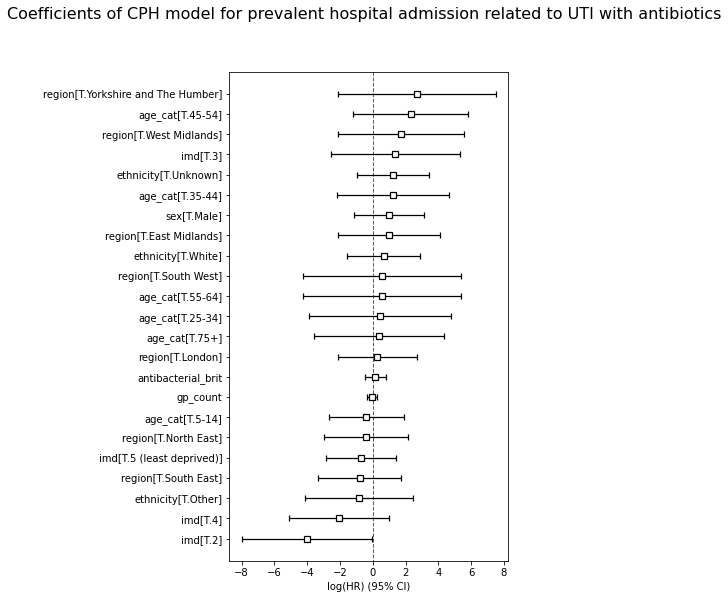

In [128]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [129]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_prevl, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'rb') as f:
#     cph_uti_abs_prevl = pickle.load(f)

# cph_uti_abs_prevl.summary

### 4-2- URTI
#### 4-2-1- Incident hospital admission related to URTI with no antibiotics

In [130]:
data_urti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'delta_urti_admitted', 'delta_admitted_died', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [131]:
data_urti_no_abs_incdt.shape

(1629, 25)

In [132]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                               'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                               'event_urti_admitted', 'duration_urti_admitted']]

In [133]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age                        0
age_cat                    0
sex                        0
bmi                       97
BMI_cat                   97
gp_count                  13
flu_vaccine                0
region                     0
antibacterial_brit         0
imd                        0
ethnicity                  0
CCI_cat                    0
CCI                        0
event_urti_admitted        0
duration_urti_admitted     0
dtype: int64

In [134]:
#drop ros with missing values
data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.drop(columns=['smoking_status'])
data_urti_no_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                       0
BMI_cat                   0
gp_count                  0
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [135]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt, 
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_urti_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 1519 total observations, 420 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1519
number of events observed = 1099
   partial log-likelihood = -6937.90
         time fit was run = 2022-02-03 15:15:00 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                     0.03       1.03       0.13            -0.21             0.28                 0.81                 1.33
age_cat[T.25-34]                    -0.22       0.81       0.13            -0.47             0.04                 0.62                 1.04
age_cat[T.35-44]                    -0.09       0.91       0.13            -0.34             0.16                 0.71                 1.17
age_cat[T.45-54]                    -0.09       0.91       0.13            -0.34             0.16                 0.71                 1.18
age_cat[T.5-14]                     -0.14       0.87       0.13            -0.39             0.10                 0.68                 1.11
age_cat[T.55-64]                     0.03       1.03       0.13            -0.22             0.27                 0.80                 1.31
age_cat[T.65-74]                     0.03       1.03       0.12            -0.22             0.27                 0.81                 1.31
age_cat[T.75+]                      -0.00       1.00       0.13            -0.26             0.26                 0.77                 1.29
antibacterial_brit                  -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
ethnicity[T.Other]                   0.22       1.25       0.16            -0.09             0.54                 0.91                 1.71
ethnicity[T.Unknown]                 0.10       1.10       0.13            -0.15             0.34                 0.86                 1.41
ethnicity[T.White]                   0.11       1.11       0.11            -0.12             0.33                 0.89                 1.39
flu_vaccine[T.Yes]                   0.13       1.14       0.10            -0.06             0.32                 0.94                 1.38
gp_count                            -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
imd[T.2]                            -0.04       0.96       0.10            -0.24             0.16                 0.79                 1.18
imd[T.3]                            -0.25       0.78       0.10            -0.45            -0.06                 0.64                 0.95
imd[T.4]                            -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
imd[T.5 (least deprived)]           -0.00       1.00       0.10            -0.20             0.19                 0.82                 1.21
imd[T.Unknown]                      -0.18       0.83       0.14            -0.45             0.09                 0.64                 1.09
region[T.East Midlands]              0.09       1.10       0.13            -0.17             0.36                 0.85                 1.43
region[T.London]                     0.13       1.14       0.12            -0.11             0.37                 0.90                 1.45
region[T.North East]                 0.14       1.15       0.14            -0.13             0.40                 0.88                 1.49
region[T.North West]                 0.13       1.13       0.14            -0.15             0.40                 0.86                 1.50
region[T.South East]                -0.01       0.99       0.14            -0.30             0.27          

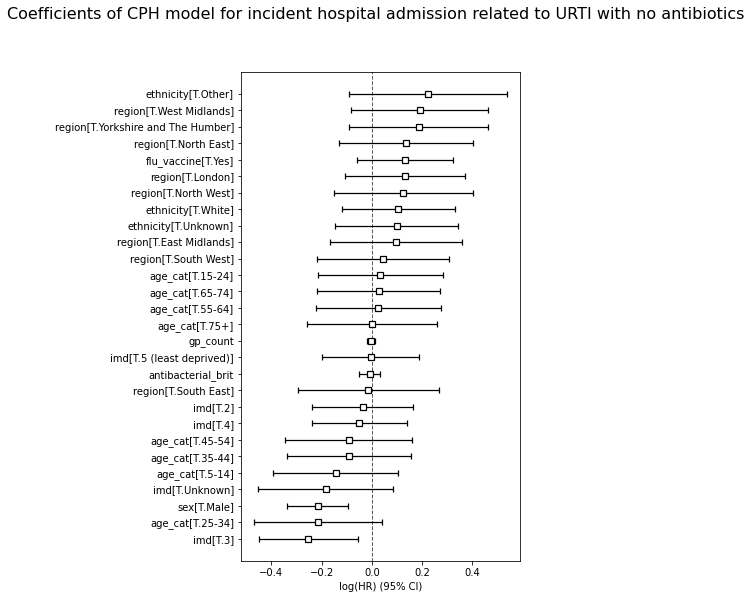

In [136]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [137]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

### 4-2-2- Incident hospital admission related to URTI with antibiotics

In [138]:
data_urti_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'delta_urti_admitted', 'delta_admitted_died', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [139]:
data_urti_abs_incdt.shape

(182, 25)

In [140]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_urti_admitted', 'duration_urti_admitted']]

In [141]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age                        0
age_cat                    0
sex                        0
bmi                       11
BMI_cat                   11
gp_count                   1
flu_vaccine                0
region                     0
antibacterial_brit         0
imd                        0
ethnicity                  0
CCI_cat                    0
CCI                        0
event_urti_admitted        0
duration_urti_admitted     0
dtype: int64

In [142]:
#drop ros with missing values
data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
#data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
data_urti_abs_incdt.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                       0
BMI_cat                   0
gp_count                  0
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [143]:
data_urti_abs_incdt.shape

(170, 15)

In [144]:
cph_urti_abs_incdt = CoxPHFitter(penalizer=0.1)
cph_urti_abs_incdt.fit(data_urti_abs_incdt, 
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 170 total observations, 45 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 170
number of events observed = 125
   partial log-likelihood = -515.96
         time fit was run = 2022-02-03 15:15:01 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                     0.10       1.10       0.31            -0.50             0.70                 0.61                 2.02
age_cat[T.25-34]                     0.17       1.19       0.33            -0.47             0.82                 0.62                 2.27
age_cat[T.35-44]                    -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.87
age_cat[T.45-54]                    -0.07       0.93       0.38            -0.81             0.66                 0.44                 1.94
age_cat[T.5-14]                      0.21       1.23       0.32            -0.41             0.83                 0.66                 2.29
age_cat[T.55-64]                    -0.01       0.99       0.32            -0.63             0.62                 0.53                 1.86
age_cat[T.65-74]                     0.63       1.88       0.32             0.00             1.27                 1.00                 3.54
age_cat[T.75+]                      -0.16       0.85       0.32            -0.79             0.47                 0.45                 1.61
antibacterial_brit                   0.09       1.09       0.06            -0.04             0.21                 0.96                 1.24
ethnicity[T.Other]                  -0.51       0.60       0.56            -1.60             0.58                 0.20                 1.79
ethnicity[T.Unknown]                -0.26       0.77       0.27            -0.79             0.27                 0.45                 1.31
ethnicity[T.White]                  -0.16       0.85       0.24            -0.64             0.31                 0.53                 1.37
flu_vaccine[T.Yes]                   0.32       1.37       0.39            -0.45             1.09                 0.64                 2.96
gp_count                             0.00       1.00       0.03            -0.05             0.05                 0.95                 1.06
imd[T.2]                             0.07       1.07       0.29            -0.50             0.64                 0.61                 1.90
imd[T.3]                            -0.29       0.75       0.25            -0.78             0.19                 0.46                 1.21
imd[T.4]                             0.15       1.16       0.26            -0.37             0.66                 0.69                 1.94
imd[T.5 (least deprived)]           -0.18       0.84       0.28            -0.73             0.38                 0.48                 1.46
imd[T.Unknown]                       0.18       1.20       0.50            -0.80             1.16                 0.45                 3.18
region[T.East Midlands]             -0.11       0.89       0.33            -0.76             0.54                 0.47                 1.71
region[T.London]                    -0.19       0.83       0.30            -0.79             0.41                 0.46                 1.51
region[T.North East]                -0.17       0.85       0.36            -0.87             0.54                 0.42                 1.71
region[T.North West]                 0.19       1.21       0.33            -0.46             0.84                 0.63                 2.33
region[T.South East]                -0.62       

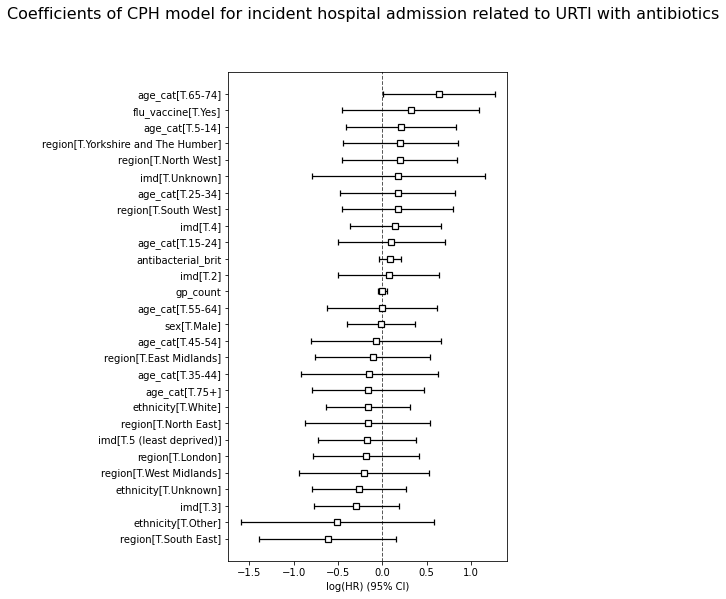

In [145]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [146]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_urti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_urti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_urti_abs_incdt.pickle', 'rb') as f:
#     cph_urti_abs_incdt = pickle.load(f)

# cph_urti_abs_incdt.summary

### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [147]:
# hosp history, ab type history, 